In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("y_train.shape",y_train.shape)
print("x_train.shape",x_train.shape)
print("y_test.shape",y_test.shape)
print("x_test.shape",x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
y_train.shape (60000,)
x_train.shape (60000, 28, 28)
y_test.shape (10000,)
x_test.shape (10000, 28, 28)


In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from keras.datasets import mnist
from keras.models import Sequential, load_model


class GAN:
    def __init__(self, numbers, epochs=100, batch_size=64, input_layer_size_g=100,
                 hidden_layer_size_g=128, hidden_layer_size_d=128, image_size=28, display_epochs=5, create_gif=True):
       
        # -------- Initialise hyperparameters --------#
        self.numbers = numbers
        self.epochs = epochs
        self.batch_size = batch_size
        self.nx_g = input_layer_size_g
        self.nh_g = hidden_layer_size_g
        self.nh_d = hidden_layer_size_d
        self.image_size = image_size
        self.display_epochs = display_epochs
        self.create_gif = create_gif
        self.gmax = 300 
        self.gmin = 150 
        self.wmax_g = 0.4
        self.wmin_g = 0
        self.wmax_d = 0.15
        self.wmin_d = 0
        self.factor_g = 1
        self.factor_w = 0.9
        self.x_fake_total = np.empty((0,784), dtype=float, order='C')
      

        self.conductance={"GW0_g":[],"Gb0_g":[],"GW1_g":[],"Gb1_g":[],"GW0_d":[],"Gb0_d":[],"GW1_d":[],"Gb1_d":[]}

        self.accuracy={"accuracy":[]};

        self.A= [[1.55e-4,-0.47,-3.851,9.369,10.4,-1.26,-0.02,0.82,-0.57,0.94],
        [1.55e-4,-0.47,-3.769,7.512,8.419,-1.22,-0.02,0.84,-0.57,0.81],
        [1.55e-4,-0.47,-3.729,6.801,7.582,-1.03,-0.02,0.72,-0.47,0.63],
        [1.55e-4,-0.47,-3.517,6.180,6.851,-0.78,-0.01,0.53,-0.33,0.45],
        [1.55e-4,-0.47,-3.426,5.946,6.558,-0.37,5e-3,0.15,-0.01,0.11],
        [1.55e-4,-0.47,-3.373,5.005,5.792,0.14,0.01,-0.29,0.31,-0.21],
        [1.55e-4,-0.47,-3.422,4.936,5.840,0.34,0.01,-0.41,0.37,-0.29],
        [1.55e-4,-0.47,-3.572,4.864,5.785,0.26,0.01,-0.29,0.25,-0.20]]

        self.B= [[-0.89e-4,0.89,8.96,6.2,-10.90,0.04,2e-4,0.02,5e-3,0.03],
        [-0.89e-4,0.51,6.88,6.2,-8.61,-5e-3,-4e-4,-2e-3,-0.01,0.02],
        [-0.89e-4,0.34,4.93,6.2,-8.14,-0.07,-3e-3,-0.07,-0.05,-0.02],
        [-0.89e-4,0.25,3.63,6.2,-7.77,-0.11,-4e-3,-0.11,-0.09,-0.03],
        [-0.89e-4,0.23,2.91,6.2,-7.42,-0.15,-6e-3,-0.17,-0.13,-0.06],
        [-0.89e-4,0.21,2.33,6.2,-7.30,-0.12,-5e-3,-0.16,-0.13,-0.06],
        [-0.89e-4,0.22,1.93,6.2,-7.10,-0.04,-2e-3,-0.10,-0.11,-0.04],
        [-0.89e-4,0.28,1.68,6.2,-7.00,0.10,3e-3,0.02,-0.05,-4e-3]]  

        self.image_dir = Path('./GAN_sample_images')  # new a folder in current directory
        if not self.image_dir.is_dir():
            self.image_dir.mkdir()

        self.filenames = []  # stores filenames of sample images if create_gif is enabled

        # -------- Initialise weights with Xavier method --------#
        # -------- Generator --------#
        self.W0_g = np.random.randn(self.nx_g, self.nh_g) * np.sqrt(2. / self.nx_g)   # 100x128
        self.b0_g = np.zeros((1, self.nh_g))  # 1x100

        self.W1_g = np.random.randn(self.nh_g, self.image_size ** 2) * np.sqrt(2. / self.nh_g)  # 128x784
        self.b1_g = np.zeros((1, self.image_size ** 2))  # 1x784

        # -------- Discriminator --------#
        self.W0_d = np.random.randn(self.image_size ** 2, self.nh_d) * np.sqrt(2. / self.image_size ** 2) # 784x128
        self.b0_d = np.zeros((1, self.nh_d))  # 1x128

        self.W1_d = np.random.randn(self.nh_d, 1) * np.sqrt(2. / self.nh_d)  # 128x1
        self.b1_d = np.zeros((1, 1))  # 1x1

        

        self.W ={"W0_g":self.W0_g,"b0_g":self.b0_g,"W1_g":self.W1_g,"b1_g":self.b1_g,"W0_d":self.W0_d,"b0_d":self.b0_d,"W1_d":self.W1_d,"b1_d":self.b1_d}


    def sigmoid(self, x):        
        return 1. / (1. + np.exp(-x))
        


    def dsigmoid(self, x):        
        y = self.sigmoid(x)
        return y * (1. - y)


    def dtanh(self, x):
        return 1. - np.tanh(x) ** 2


    def lrelu(self, x, alpha=1e-2):
        return np.maximum(x, x * alpha)


    def dlrelu(self, x, alpha=1e-2):
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx


    def forward_generator(self, z):        
        self.z0_g = np.dot(z, self.W0_g) + self.b0_g
        self.a0_g = self.lrelu(self.z0_g, alpha=0)

        self.z1_g = np.dot(self.a0_g, self.W1_g) + self.b1_g
        self.a1_g = np.tanh(self.z1_g)  # check: range -1 to 1 as real images

        return self.z1_g, self.a1_g


    def forward_discriminator(self, x):        
        self.z0_d = np.dot(x, self.W0_d) + self.b0_d
        self.a0_d = self.lrelu(self.z0_d)

        self.z1_d = np.dot(self.a0_d, self.W1_d) + self.b1_d
        self.a1_d = self.sigmoid(self.z1_d)  # check: output probability between [0,1]

        return self.z1_d, self.a1_d


    def range(self,G):
       if (G<=5.16): return 0
       if (G<=10): return 1
       if (G<=17.8): return 2
       if (G<=31.6): return 3
       if (G<=56.2): return 4
       if (G<=100): return 5
       if (G<=178): return 6
       else: return 7

    def c0s(self,G): 
      k=self.range(G) 
      return self.A[k][0]
    def c1s(self,G): 
      k=self.range(G)
      return self.A[k][1]
    def c2s(self,G): 
      k=self.range(G)
      return self.A[k][2]
    def c3s(self,G): 
      k=self.range(G)
      return self.A[k][3]
    def c4s(self,G): 
      k=self.range(G)
      return self.A[k][4]
    def d0s(self,G): 
      k=self.range(G)
      return self.A[k][5]
    def d1s(self,G): 
      k=self.range(G)
      return self.A[k][6]
    def d2s(self,G): 
      k=self.range(G)
      return self.A[k][7]
    def d3s(self,G): 
      k=self.range(G)
      return self.A[k][8]
    def d4s(self,G): 
      k=self.range(G)
      return self.A[k][9]

    def c0r(self,G): 
      k=self.range(G) 
      return self.B[k][0]
    def c1r(self,G): 
      k=self.range(G)
      return self.B[k][1]
    def c2r(self,G): 
      k=self.range(G)
      return self.B[k][2]
    def c3r(self,G): 
      k=self.range(G)
      return self.B[k][3]
    def c4r(self,G): 
      k=self.range(G)
      return self.B[k][4]
    def d0r(self,G): 
      k=self.range(G)
      return self.B[k][5]
    def d1r(self,G): 
      k=self.range(G)
      return self.B[k][6]
    def d2r(self,G): 
      k=self.range(G)
      return self.B[k][7]
    def d3r(self,G): 
      k=self.range(G)
      return self.B[k][8]
    def d4r(self,G): 
      k=self.range(G)
      return self.B[k][9]
    

    def deltaG(self,dW,G,sgn):
        tp=100
        Vps=0.8
        Vpr=-0.8
        if sgn:
          if dW>0:
            deltaG = abs(self.c0s(G)*(1-np.tanh(self.c1s(G)*(np.log(tp)-self.c2s(G))))*(np.tanh(self.c3s(G)*Vps-self.c4s(G))+1)) 
          else:
            deltaG = -abs(self.c0r(G)*(-1-np.tanh(self.c1r(G)*(np.log(tp)-self.c2r(G))))*(np.tanh(self.c3r(G)*Vpr-self.c4r(G))-1))
          return deltaG *1e6
        else:
          if dW<0:
            deltaG = abs(self.c0s(G)*(1-np.tanh(self.c1s(G)*(np.log(tp)-self.c2s(G))))*(np.tanh(self.c3s(G)*Vps-self.c4s(G))+1))
          else:
            deltaG = -abs(self.c0r(G)*(-1-np.tanh(self.c1r(G)*(np.log(tp)-self.c2r(G))))*(np.tanh(self.c3r(G)*Vpr-self.c4r(G))-1))
          return deltaG *1e6
        



    def backward_discriminator(self, x_real, z1_real, a1_real, x_fake, z1_fake, a1_fake):
        da1_real = -1. / (a1_real + 1e-8)  # 64x1

        dz1_real = da1_real * self.dsigmoid(z1_real)  # 64x1
        dW1_real = np.dot(self.a0_d.T, dz1_real)
        db1_real = np.sum(dz1_real, axis=0, keepdims=True)

        da0_real = np.dot(dz1_real, self.W1_d.T)
        dz0_real = da0_real * self.dlrelu(self.z0_d)
        dW0_real = np.dot(x_real.T, dz0_real)
        db0_real = np.sum(dz0_real, axis=0, keepdims=True)

        # fake input gradients -np.log(1 - a1_fake)
        da1_fake = 1. / (1. - a1_fake + 1e-8)

        dz1_fake = da1_fake * self.dsigmoid(z1_fake)
        dW1_fake = np.dot(self.a0_d.T, dz1_fake)
        db1_fake = np.sum(dz1_fake, axis=0, keepdims=True)

        da0_fake = np.dot(dz1_fake, self.W1_d.T)
        dz0_fake = da0_fake * self.dlrelu(self.z0_d, alpha=0)
        dW0_fake = np.dot(x_fake.T, dz0_fake)
        db0_fake = np.sum(dz0_fake, axis=0, keepdims=True)

        # -------- Combine gradients for real & fake images--------#
        dW1 = dW1_real + dW1_fake
        db1 = db1_real + db1_fake

        dW0 = dW0_real + dW0_fake
        db0 = db0_real + db0_fake


        GW0_d = self.gmin + (self.gmax-self.gmin)/(self.wmax_d-self.wmin_d) * (abs(self.W0_d)-self.wmin_d) * self.factor_g
        Gb0_d = self.gmin + (self.gmax-self.gmin)/(self.wmax_d-self.wmin_d) * (abs(self.b0_d)-self.wmin_d) * self.factor_g
        GW1_d = self.gmin + (self.gmax-self.gmin)/(self.wmax_d-self.wmin_d) * (abs(self.W1_d)-self.wmin_d) * self.factor_g
        Gb1_d = self.gmin + (self.gmax-self.gmin)/(self.wmax_d-self.wmin_d) * (abs(self.b1_d)-self.wmin_d) * self.factor_g

        self.conductance["GW0_d"].append(GW0_d)
        self.conductance["Gb0_d"].append(Gb0_d)
        self.conductance["GW1_d"].append(GW1_d)	
        self.conductance["Gb1_d"].append(Gb1_d)
        
        

        for i in range(0,783):
          for j in range(0,127):
            GW0_d[i][j] += self.deltaG(dW0[i][j],GW0_d[i][j],self.W0_d[i][j]>0)
            if GW0_d[i][j]>self.gmax:
                GW0_d[i][j]=self.gmax
            elif GW0_d[i][j]<self.gmin:
                GW0_d[i][j]=self.gmin
            self.W0_d[i][j] = (1 if self.W0_d[i][j]>0 else -1)* ((GW0_d[i][j]-self.gmin)*(self.wmax_d-self.wmin_d) /(self.gmax-self.gmin))* self.factor_w + self.wmin_d
        
        for i in range(0,0):
          for j in range(0,127):
            Gb0_d[i][j] += self.deltaG(db0[i][j],Gb0_d[i][j],self.b0_d[i][j]>0) 
            if Gb0_d[i][j]>self.gmax:
                Gb0_d[i][j]=self.gmax
            elif Gb0_d[i][j]<self.gmin:
                Gb0_d[i][j]=self.gmin 
            self.b0_d[i][j] =(1 if self.b0_d[i][j]>0 else -1)*((Gb0_d[i][j]-self.gmin)*(self.wmax_d-self.wmin_d) /(self.gmax-self.gmin))* self.factor_w + self.wmin_d
            

        
        for i in range(0,127):
          for j in range(0,0):
            GW1_d[i][j] += self.deltaG(dW1[i][j],GW1_d[i][j],self.W1_d[i][j]>0) 
            if GW1_d[i][j]>self.gmax:
                GW1_d[i][j]=self.gmax
            elif GW1_d[i][j]<self.gmin:
                GW1_d[i][j]=self.gmin
            self.W1_d[i][j] = (1 if self.W1_d[i][j]>0 else -1)*((GW1_d[i][j]-self.gmin)*(self.wmax_d-self.wmin_d) /(self.gmax-self.gmin))* self.factor_w + self.wmin_d
            
        

        
        for i in range(0,0):
          for j in range(0,0):
            Gb1_d[i][j] += self.deltaG(db1[i][j],Gb1_d[i][j],self.b1_d[i][j]>0)
            if Gb1_d[i][j]>self.gmax:
                Gb1_d[i][j]=self.gmax
            elif Gb1_d[i][j]<self.gmin:
                Gb1_d[i][j]=self.gmin
            self.b1_d[i][j] = (1 if self.b1_d[i][j]>0 else -1)* ((Gb1_d[i][j]-self.gmin)*(self.wmax_d-self.wmin_d) /(self.gmax-self.gmin))* self.factor_w + self.wmin_d
            
        


    def backward_generator(self, z, x_fake, z1_fake, a1_fake):
        # -------- Backprop through Discriminator --------#
        # J_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))

        # fake input gradients -np.log(1 - a1_fake)
        da1_d = -1.0 / (a1_fake + 1e-8)  # 64x1

        dz1_d = da1_d * self.dsigmoid(z1_fake)
        da0_d = np.dot(dz1_d, self.W1_d.T)
        dz0_d = da0_d * self.dlrelu(self.z0_d)
        dx_d = np.dot(dz0_d, self.W0_d.T)

        # -------- Backprop through Generator --------#
        # J_G = np.mean(-np.log(1 - a1_fake))
        # fake input gradients -np.log(1 - a1_fake)
        dz1_g = dx_d * self.dtanh(self.z1_g)
        dW1_g = np.dot(self.a0_g.T, dz1_g)
        db1_g = np.sum(dz1_g, axis=0, keepdims=True)

        da0_g = np.dot(dz1_g, self.W1_g.T)
        dz0_g = da0_g * self.dlrelu(self.z0_g, alpha=0)
        dW0_g = np.dot(z.T, dz0_g)
        db0_g = np.sum(dz0_g, axis=0, keepdims=True)


        GW0_g = self.gmin + (self.gmax-self.gmin)/(self.wmax_g-self.wmin_g) * (abs(self.W0_g)-self.wmin_g) * self.factor_g
        Gb0_g = self.gmin + (self.gmax-self.gmin)/(self.wmax_g-self.wmin_g) * (abs(self.b0_g)-self.wmin_g) * self.factor_g
        GW1_g = self.gmin + (self.gmax-self.gmin)/(self.wmax_g-self.wmin_g) * (abs(self.W1_g)-self.wmin_g) * self.factor_g
        Gb1_g = self.gmin + (self.gmax-self.gmin)/(self.wmax_g-self.wmin_g) * (abs(self.b1_g)-self.wmin_g) * self.factor_g

        self.conductance["GW0_g"].append(GW0_g)
        self.conductance["Gb0_g"].append(Gb0_g)
        self.conductance["GW1_g"].append(GW1_g)	
        self.conductance["Gb1_g"].append(Gb1_g)

        for i in range(0,99):
          for j in range(0,127):
            GW0_g[i][j] += self.deltaG(dW0_g[i][j],GW0_g[i][j],self.W0_g[i][j]>0)
            if GW0_g[i][j]>self.gmax:
                GW0_g[i][j]=self.gmax
            elif GW0_g[i][j]<self.gmin:
                GW0_g[i][j]=self.gmin
            self.W0_g[i][j] =(1 if self.W0_g[i][j]>0 else -1)* ((GW0_g[i][j]-self.gmin)*(self.wmax_g-self.wmin_g) /(self.gmax-self.gmin))* self.factor_w + self.wmin_g
           

        
        for i in range(0,0):
          for j in range(0,99):
            Gb0_g[i][j] += self.deltaG(db0_g[i][j],Gb0_g[i][j],self.b0_g[i][j]>0) 
            if Gb0_g[i][j]>self.gmax:
                Gb0_g[i][j]=self.gmax
            elif Gb0_g[i][j]<self.gmin:
                Gb0_g[i][j]=self.gmin 
            self.b0_g[i][j] =(1 if self.b0_g[i][j]>0 else -1)* ((Gb0_g[i][j]-self.gmin)*(self.wmax_g-self.wmin_g) /(self.gmax-self.gmin))* self.factor_w + self.wmin_g
            
        
        for i in range(0,127):
          for j in range(0,783):
            GW1_g[i][j] += self.deltaG(dW1_g[i][j],GW1_g[i][j],self.W1_g[i][j]>0) 
            if GW1_g[i][j]>self.gmax:
                GW1_g[i][j]=self.gmax
            elif GW1_g[i][j]<self.gmin:
                GW1_g[i][j]=self.gmin
            self.W1_g[i][j] = (1 if self.W1_g[i][j]>0 else -1)*((GW1_g[i][j]-self.gmin)*(self.wmax_g-self.wmin_g) /(self.gmax-self.gmin))* self.factor_w + self.wmin_g
            

        
        for i in range(0,0):
          for j in range(0,0):
            Gb1_g[i][j] += self.deltaG(db1_g[i][j],Gb1_g[i][j],self.b1_g[i][j]>0)
            if Gb1_g[i][j]>self.gmax:
                Gb1_g[i][j]=self.gmax
            elif Gb1_g[i][j]<self.gmin:
                Gb1_g[i][j]=self.gmin
            self.b1_g[i][j] =(1 if self.b1_g[i][j]>0 else -1)* ((Gb1_g[i][j]-self.gmin)*(self.wmax_g-self.wmin_g) /(self.gmax-self.gmin))* self.factor_w + self.wmin_g
            



    def preprocess_data(self, x, y):
        x_train = []
        y_train = []

        # limit the data to a subset of digits from 0-9
        for i in range(y.shape[0]):
            if y[i] in self.numbers:
                x_train.append(x[i])
                y_train.append(y[i])

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        # limit the data to full batches only
        num_batches = x_train.shape[0] // self.batch_size
        x_train = x_train[: num_batches * self.batch_size]
        y_train = y_train[: num_batches * self.batch_size]

        # flatten the images (_,28,28)->(_, 784)
        x_train = np.reshape(x_train, (x_train.shape[0], -1))
        
        # normalise the data to the range [-1,1]
        x_train = (x_train.astype(np.float32) - 127.5) / 127.5
        
        # shuffle the data
        idx = np.random.permutation(len(x_train))
        x_train, y_train = x_train[idx], y_train[idx]
        return x_train, y_train, num_batches

    def sample_images(self, images, epoch, show):
        images = np.reshape(images, (self.batch_size, self.image_size, self.image_size))

        fig = plt.figure(figsize=(4, 4))

        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        # saves generated images in the GAN_sample_images folder
        if self.create_gif:
            current_epoch_filename = self.image_dir.joinpath(f"GAN_epoch{epoch}.png")
            self.filenames.append(current_epoch_filename)
            plt.savefig(current_epoch_filename)

        if show == True:
            plt.show()
        else:
            plt.close()


    def generate_gif(self):
        images = []
        for filename in self.filenames:
            images.append(imageio.imread(filename))
        imageio.mimsave("GAN.gif", images)

    def classifier(self,x_fake_total):
        sz = self.x_fake_total.shape[0]
        images = np.reshape(x_fake_total, (sz, model.image_size, model.image_size))
        images = images * 127.5 + 127.5
        images = images.astype('int')
        mnist_model = load_model('keras_mnist.h5')
        
        

        X_test = images
        X_test = X_test.reshape(sz, 784)
        X_test = X_test.astype('float32')
        X_test /= 255

        predicted_classes = mnist_model.predict_classes(X_test)

        y_test = np.ones(sz) *self.numbers

        # see which we predicted correctly and which not
        correct_indices = np.nonzero(predicted_classes == y_test)[0]
        incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
        
        acc = len(correct_indices) * 100 / (len(correct_indices)+len(incorrect_indices))

        self.accuracy["accuracy"].append(acc)	

        return acc


    def train(self, x, y):
        J_Ds = []  # stores the disciminator losses
        J_Gs = []  # stores the generator losses

        # preprocess input; note that labels aren't needed
        x_train, _, num_batches = self.preprocess_data(x, y)

        import matplotlib.pyplot as plt 

        '''
        from scipy.io import loadmat
        annots = loadmat('zf.mat')
        zf=annots['zf']
        '''

        for epoch in range(self.epochs):

            for i in range(num_batches):
                # ------- PREPARE INPUT BATCHES & NOISE -------#

                x_real = x_train[i * self.batch_size: (i + 1) * self.batch_size]                
                
                #z = zf[i*epoch:i*epoch+64]       -- true random noise data

                z = np.random.normal(0, 1, size=[self.batch_size, self.nx_g]) 

                #z = np.random.normal(0, 1, size=[self.batch_size, self.nx_g])  # 64x100 -- Pseudo random noise
                # ------- FORWARD PROPAGATION -------#
                z1_g, x_fake = self.forward_generator(z)

                self.x_fake_total = np.append(self.x_fake_total,x_fake,axis=0);

                acc = self.classifier(self.x_fake_total);
                

                z1_d_real, a1_d_real = self.forward_discriminator(x_real)
                z1_d_fake, a1_d_fake = self.forward_discriminator(x_fake)

                # ------- CROSS ENTROPY LOSS -------#
                # ver1 : max log(D(x)) + log(1 - D(G(z))) (in original paper)
                # ver2 : min -log(D(x)) min log(1 - D(G(z))) (implemented here)
                J_D = np.mean(-np.log(a1_d_real+1e-8) - np.log(1 - a1_d_fake+1e-8))
                J_Ds.append(J_D)

                # ver1 : minimize log(1 - D(G(z))) (in original paper)
                # ver2 : maximize log(D(G(z)))
                # ver3 : minimize -log(D(G(z))) (implemented here)
                J_G = np.mean(-np.log(a1_d_fake+1e-8))
                J_Gs.append(J_G)
                # ------- BACKWARD PROPAGATION -------#
                self.backward_discriminator(x_real, z1_d_real, a1_d_real,
                                            x_fake, z1_d_fake, a1_d_fake)
                self.backward_generator(z, x_fake, z1_d_fake, a1_d_fake)

                if i % 1 == 0:
                    print(
                    f"Epoch:{epoch:}|Batch:{i:}|Accuracy:{acc:}|G loss:{J_G:.4f}|D loss:{J_D:.4f}|D(G(z))avg:{np.mean(a1_d_fake+1e-8):.4f}|D(x)avg:{np.mean(a1_d_real+1e-8):.4f}")
                    self.sample_images(x_fake, epoch, show=True)  # display sample images
                else:
                    self.sample_images(x_fake, epoch, show=False)
            

        # generate gif
        if self.create_gif:
            self.generate_gif()


          
        return J_Ds, J_Gs

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch:0|Batch:0|Accuracy:0.0|G loss:1.0412|D loss:1.9623|D(G(z))avg:0.3873|D(x)avg:0.2640


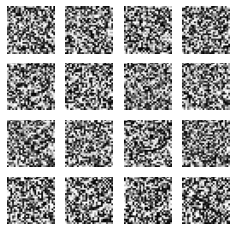

Epoch:0|Batch:1|Accuracy:39.0625|G loss:18.4204|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


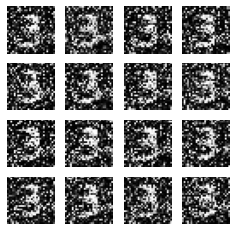

Epoch:0|Batch:2|Accuracy:59.375|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


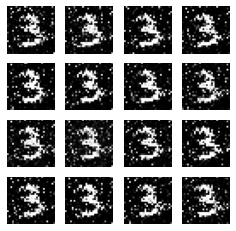

Epoch:0|Batch:3|Accuracy:69.53125|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


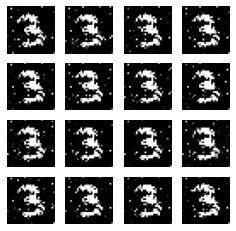

Epoch:0|Batch:4|Accuracy:75.625|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


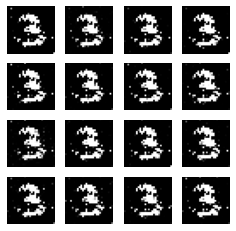

Epoch:0|Batch:5|Accuracy:79.6875|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


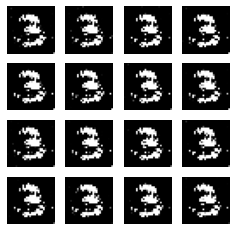

Epoch:0|Batch:6|Accuracy:82.58928571428571|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


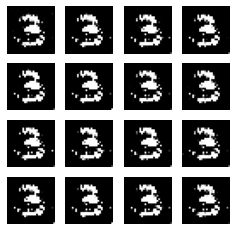

Epoch:0|Batch:7|Accuracy:84.765625|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


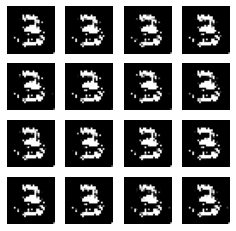

Epoch:0|Batch:8|Accuracy:86.45833333333333|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


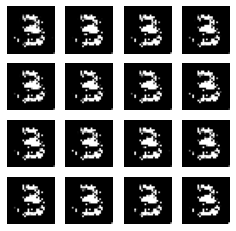

Epoch:0|Batch:9|Accuracy:87.8125|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


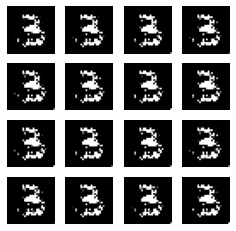

Epoch:0|Batch:10|Accuracy:88.92045454545455|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


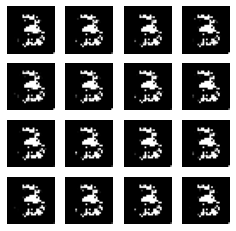

Epoch:0|Batch:11|Accuracy:89.84375|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


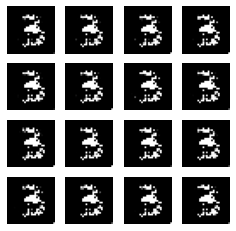

Epoch:0|Batch:12|Accuracy:90.625|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


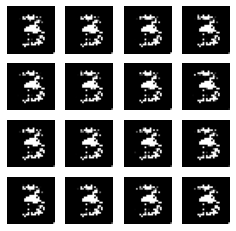

Epoch:0|Batch:13|Accuracy:91.29464285714286|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


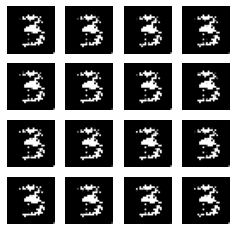

Epoch:0|Batch:14|Accuracy:91.875|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


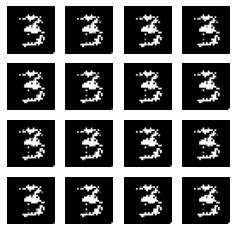

Epoch:0|Batch:15|Accuracy:92.3828125|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


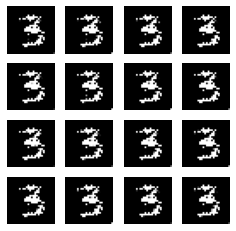

Epoch:0|Batch:16|Accuracy:92.83088235294117|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


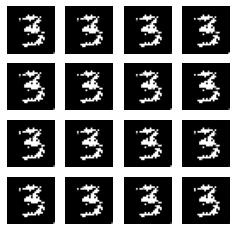

Epoch:0|Batch:17|Accuracy:93.22916666666667|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


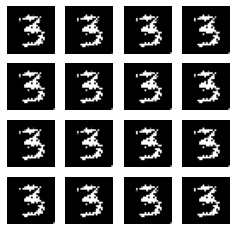

Epoch:0|Batch:18|Accuracy:93.58552631578948|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


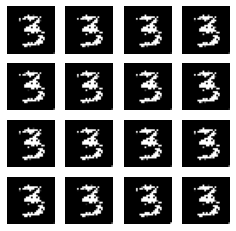

Epoch:0|Batch:19|Accuracy:93.90625|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


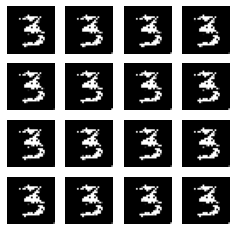

Epoch:0|Batch:20|Accuracy:94.19642857142857|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


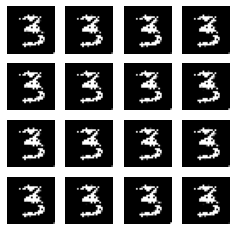

Epoch:0|Batch:21|Accuracy:94.46022727272727|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


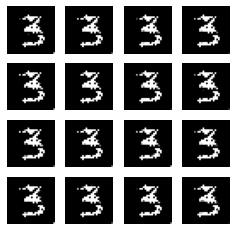

Epoch:0|Batch:22|Accuracy:94.70108695652173|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


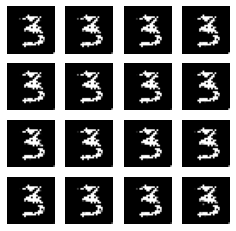

Epoch:0|Batch:23|Accuracy:94.921875|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


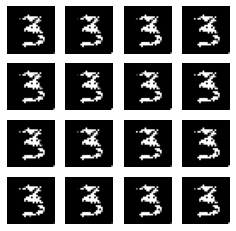

Epoch:0|Batch:24|Accuracy:95.125|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


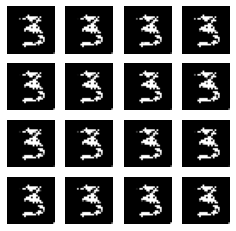

Epoch:0|Batch:25|Accuracy:95.3125|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


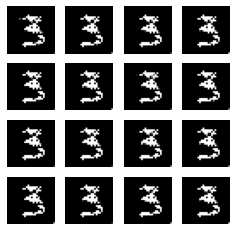

Epoch:0|Batch:26|Accuracy:95.48611111111111|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


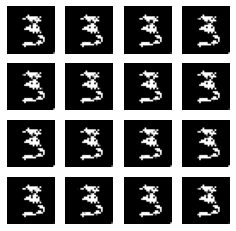

Epoch:0|Batch:27|Accuracy:95.64732142857143|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


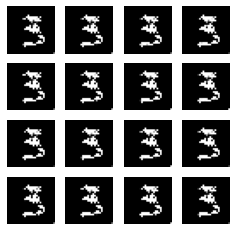

Epoch:0|Batch:28|Accuracy:95.79741379310344|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


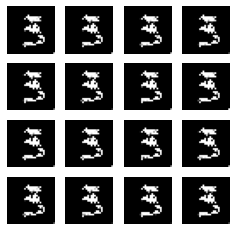

Epoch:0|Batch:29|Accuracy:95.9375|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


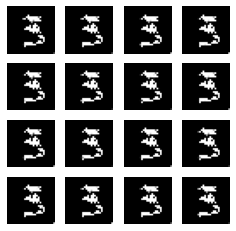

Epoch:0|Batch:30|Accuracy:96.06854838709677|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


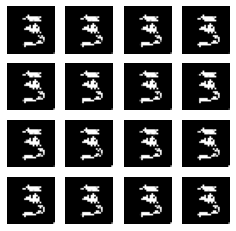

Epoch:0|Batch:31|Accuracy:96.19140625|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


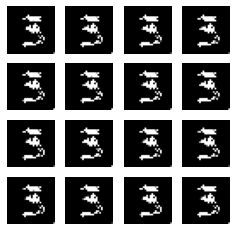

Epoch:0|Batch:32|Accuracy:96.30681818181819|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


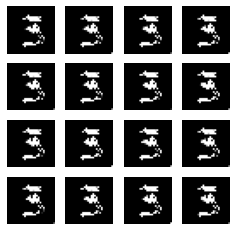

Epoch:0|Batch:33|Accuracy:96.4154411764706|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


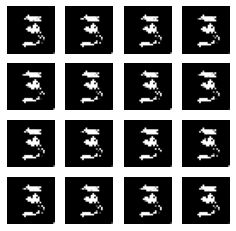

Epoch:0|Batch:34|Accuracy:96.51785714285714|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


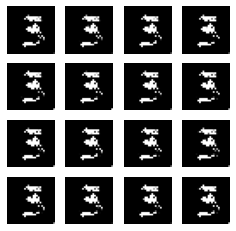

Epoch:0|Batch:35|Accuracy:96.61458333333333|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


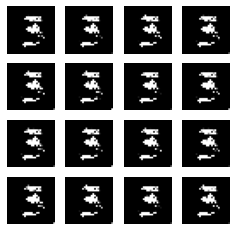

Epoch:0|Batch:36|Accuracy:96.70608108108108|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


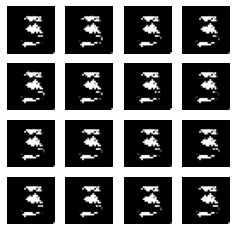

Epoch:0|Batch:37|Accuracy:96.79276315789474|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


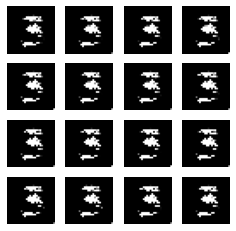

Epoch:0|Batch:38|Accuracy:96.875|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


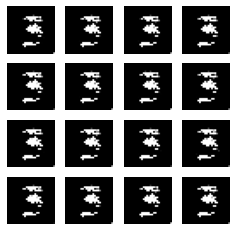

Epoch:0|Batch:39|Accuracy:96.953125|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


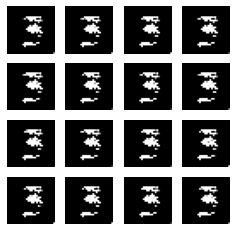

Epoch:0|Batch:40|Accuracy:97.02743902439025|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


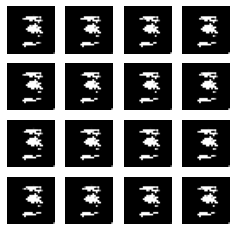

Epoch:0|Batch:41|Accuracy:97.09821428571429|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


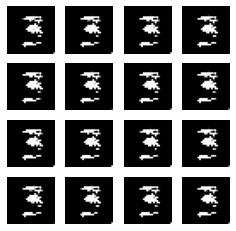

Epoch:0|Batch:42|Accuracy:97.16569767441861|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


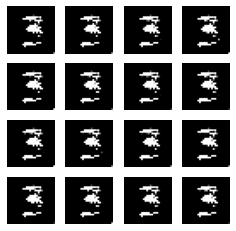

Epoch:0|Batch:43|Accuracy:97.23011363636364|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


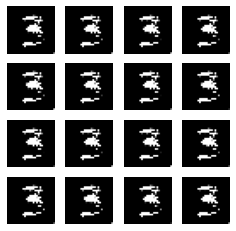

Epoch:0|Batch:44|Accuracy:97.29166666666667|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


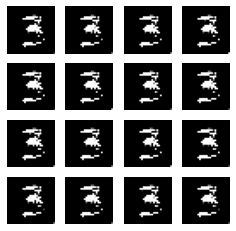

Epoch:0|Batch:45|Accuracy:97.35054347826087|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


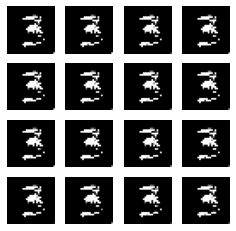

Epoch:0|Batch:46|Accuracy:97.40691489361703|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


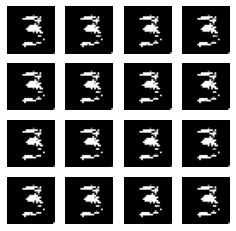

Epoch:0|Batch:47|Accuracy:97.4609375|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


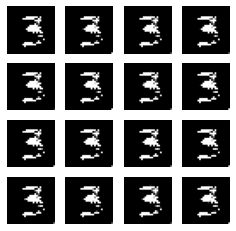

Epoch:0|Batch:48|Accuracy:97.51275510204081|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


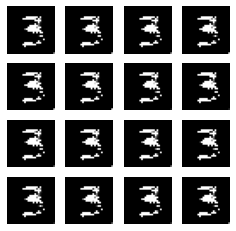

Epoch:0|Batch:49|Accuracy:97.5625|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


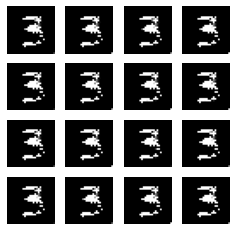

Epoch:0|Batch:50|Accuracy:97.61029411764706|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


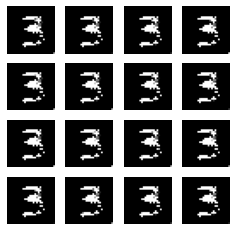

Epoch:0|Batch:51|Accuracy:97.65625|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


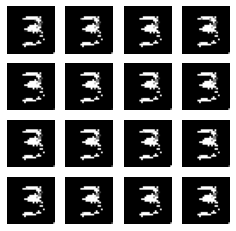

Epoch:0|Batch:52|Accuracy:97.7004716981132|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


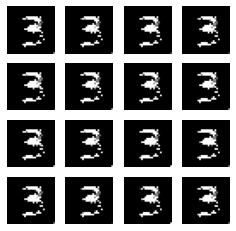

Epoch:0|Batch:53|Accuracy:97.74305555555556|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


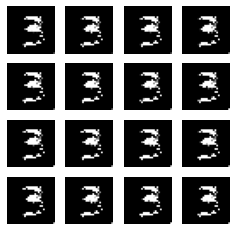

Epoch:0|Batch:54|Accuracy:97.7840909090909|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


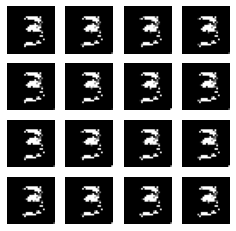

Epoch:0|Batch:55|Accuracy:97.82366071428571|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


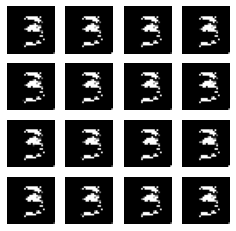

Epoch:0|Batch:56|Accuracy:97.86184210526316|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


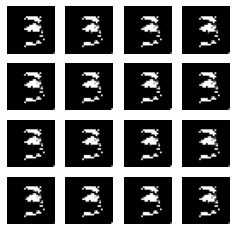

Epoch:0|Batch:57|Accuracy:97.89870689655173|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


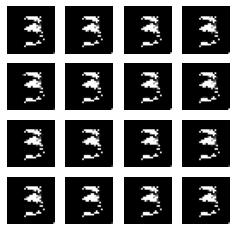

Epoch:0|Batch:58|Accuracy:97.93432203389831|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


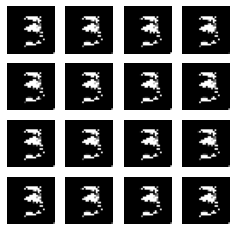

Epoch:0|Batch:59|Accuracy:97.96875|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


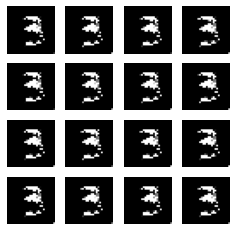

Epoch:0|Batch:60|Accuracy:98.00204918032787|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


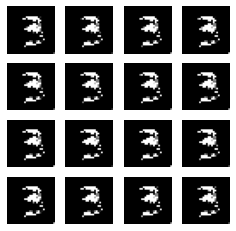

Epoch:0|Batch:61|Accuracy:98.03427419354838|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


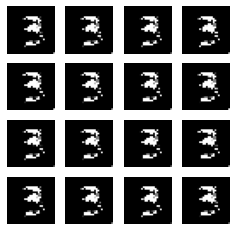

Epoch:0|Batch:62|Accuracy:98.06547619047619|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


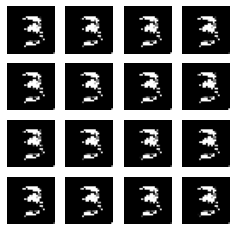

Epoch:0|Batch:63|Accuracy:98.095703125|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


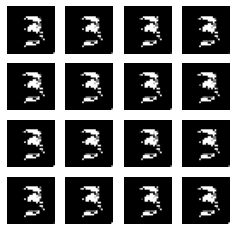

Epoch:0|Batch:64|Accuracy:98.125|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


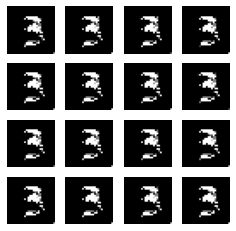

Epoch:0|Batch:65|Accuracy:98.1534090909091|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


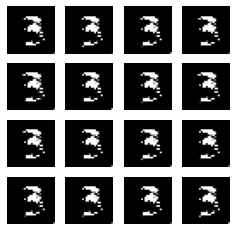

Epoch:0|Batch:66|Accuracy:98.18097014925372|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


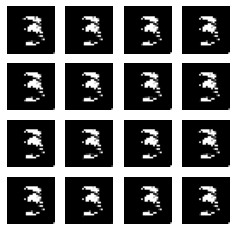

Epoch:0|Batch:67|Accuracy:98.20772058823529|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


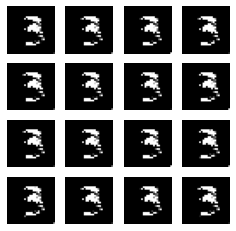

Epoch:0|Batch:68|Accuracy:98.2336956521739|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


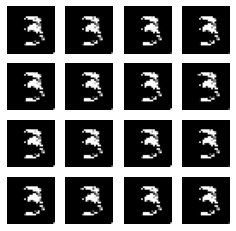

Epoch:0|Batch:69|Accuracy:98.25892857142857|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


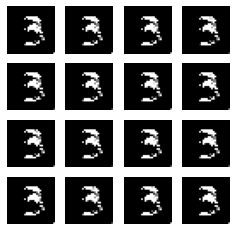

Epoch:0|Batch:70|Accuracy:98.28345070422536|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


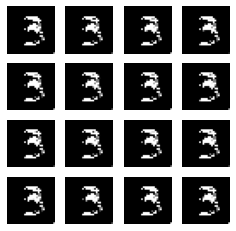

Epoch:0|Batch:71|Accuracy:98.30729166666667|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


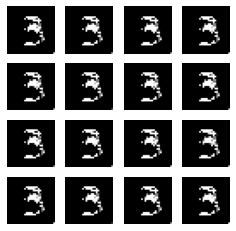

Epoch:0|Batch:72|Accuracy:98.33047945205479|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


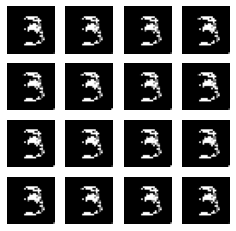

Epoch:0|Batch:73|Accuracy:98.35304054054055|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


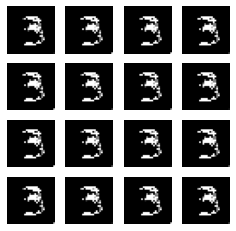

Epoch:0|Batch:74|Accuracy:98.375|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


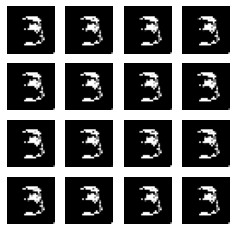

Epoch:0|Batch:75|Accuracy:98.39638157894737|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


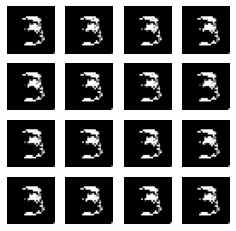

Epoch:0|Batch:76|Accuracy:98.41720779220779|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


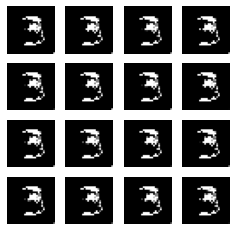

Epoch:0|Batch:77|Accuracy:98.4375|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


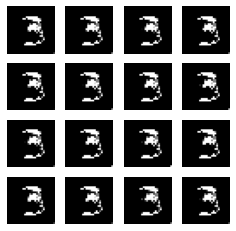

Epoch:0|Batch:78|Accuracy:98.45727848101266|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


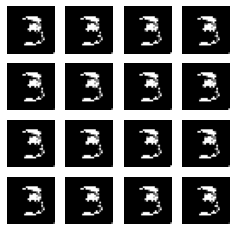

Epoch:0|Batch:79|Accuracy:98.4765625|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


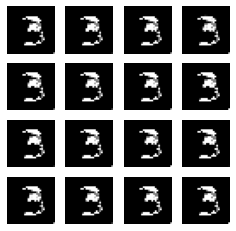

Epoch:0|Batch:80|Accuracy:98.49537037037037|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


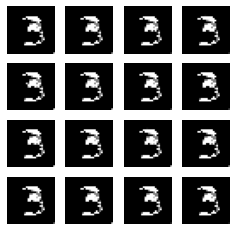

Epoch:0|Batch:81|Accuracy:98.51371951219512|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


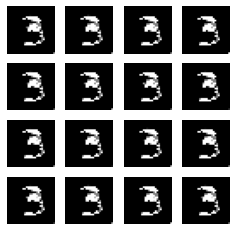

Epoch:0|Batch:82|Accuracy:98.5316265060241|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


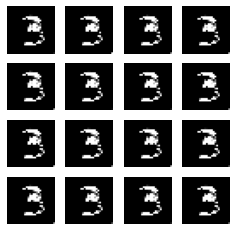

Epoch:0|Batch:83|Accuracy:98.54910714285714|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


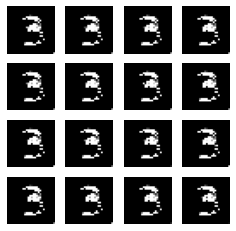

Epoch:0|Batch:84|Accuracy:98.56617647058823|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


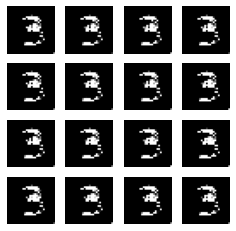

Epoch:0|Batch:85|Accuracy:98.5828488372093|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


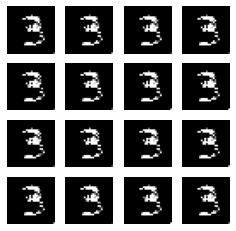

Epoch:0|Batch:86|Accuracy:98.59913793103448|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


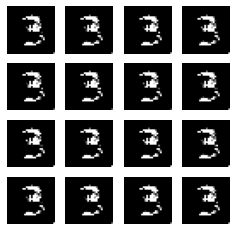

Epoch:0|Batch:87|Accuracy:98.61505681818181|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


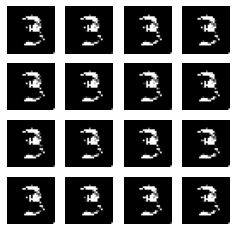

Epoch:0|Batch:88|Accuracy:98.63061797752809|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


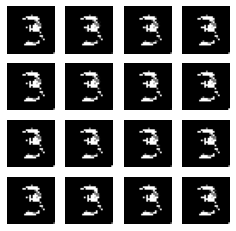

Epoch:0|Batch:89|Accuracy:98.64583333333333|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


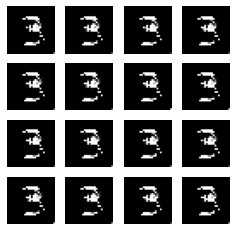

Epoch:0|Batch:90|Accuracy:98.66071428571429|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


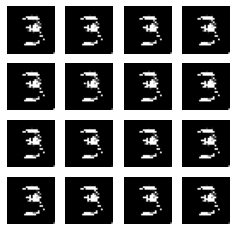

Epoch:0|Batch:91|Accuracy:98.67527173913044|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


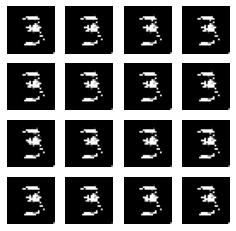

Epoch:0|Batch:92|Accuracy:98.68951612903226|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


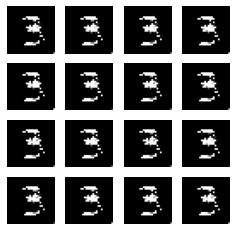

Epoch:0|Batch:93|Accuracy:98.70345744680851|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


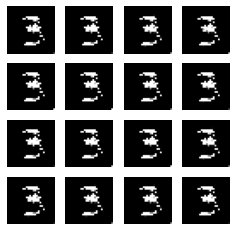

Epoch:0|Batch:94|Accuracy:98.71710526315789|G loss:18.4207|D loss:18.4207|D(G(z))avg:0.0000|D(x)avg:0.0000


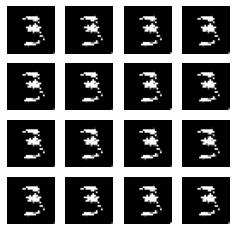

In [ ]:
numbers = [3]

model = GAN(numbers, epochs=1)
J_Ds, J_Gs = model.train(x_train, y_train)

In [ ]:
from scipy.io import savemat
savemat("conductance.mat", model.conductance)
savemat("initial_weights.mat", model.W)
savemat("accuracy.mat",model.accuracy)

(64, 28, 28)


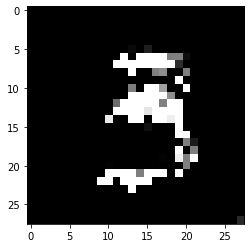

In [ ]:
from scipy.io import loadmat
#annots = loadmat('zf.mat')
#zf=annots['zf']
z = np.random.normal(0, 1, size=[model.batch_size, model.nx_g]) 


z1_g, x_fake = model.forward_generator(z)

from scipy.io import savemat


images = np.reshape(x_fake, (model.batch_size, model.image_size, model.image_size))
images = images * 127.5 + 127.5
images = images.astype('int')
imag = {"x_fake":images}

savemat("imag.mat", imag)

print(images.shape)
plt.imshow(images[57] , cmap='gray')


In [ ]:
from scipy.io import loadmat
annots = loadmat('zf.mat')
zf=annots['zf']

z = zf[64:128]
print(z.shape)

(64, 100)


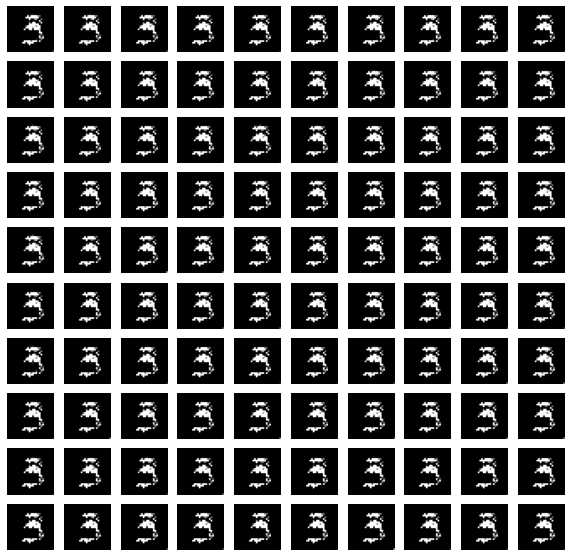

In [ ]:
from scipy.io import loadmat
#annots = loadmat('zf.mat')
#zf=annots['zf']
z = np.random.normal(0, 1, size=[model.batch_size, model.nx_g]) 

#z =zf[0:64]
z1, x1 = model.forward_generator(z)
images = np.reshape(x1, (model.batch_size, model.image_size, model.image_size))
images = images * 127.5 + 127.5
images = images.astype('int')
x_fake = images


for i in range(1,50):
    #z= zf[64*i:64*(i+1)]
    z = np.random.normal(0, 1, size=[model.batch_size, model.nx_g])
    z1, x1 = model.forward_generator(z)

    images = np.reshape(x1, (model.batch_size, model.image_size, model.image_size))
    images = images * 127.5 + 127.5
    images = images.astype('int')
    x_fake = np.append(x_fake,images,axis=0);

fig = plt.figure(figsize=(10, 10))

for i in range(100):
      plt.subplot(10, 10, i + 1)
      plt.imshow(x_fake[10*i], cmap='gray')
      plt.axis('off')

imag = {"x_fake":x_fake}

savemat("imag.mat", imag)

#print(images.shape)
#plt.imshow(images[57] , cmap='copper')
